# Packages

## Global Packages

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import sys
import json
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf

SAMPLE_RATE = 16000


## Personal Packages

In [3]:
from packages.utils import get_and_convert_file_size

from packages.features import create_train_audio_dataset
from packages.features import create_test_audio_dataset
from packages.features import preprocess_melspec_audio_datasets

from packages.model import model
from packages.model import evaluate_model
from packages.model import plot_training_history
from packages.model import plot_confusion_matrix
from packages.model import compile_and_train_model

# Path to the datasets

In [4]:
train_data_dir = pathlib.Path('Dataset/Train')
test_data_dir = pathlib.Path('Dataset/Test')

train_data_needs_preprocessing = pathlib.Path('Dataset/Train_need_preprocessing')
test_data_needs_preprocessing = pathlib.Path('Dataset/Test_need_preprocessing')

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')
# DATASET_PATH = "/content/drive/My Drive/Luganda/Dataset"
# data_dir = pathlib.Path(DATASET_PATH)

# Exploratory Data Analysis

## Labels

In [6]:
def list_directory_contents(directory, label):
    contents = np.array(tf.io.gfile.listdir(str(directory)))
    print(f'{label} commands labels: {contents}')
    return contents

In [7]:

train_commands = list_directory_contents(train_data_dir, 'Train')
test_commands = list_directory_contents(test_data_dir, 'Test')

Train commands labels: ['emabega' 'unknown' 'ddyo' 'yimirira' 'kkono' 'mumaaso']
Test commands labels: ['emabega' 'unknown' 'ddyo' 'yimirira' 'kkono' 'mumaaso']


## Load sample audio files

In [8]:
emabega_file_path = os.path.join(test_data_dir, 'emabega', 'emabega_1.wav')
ddyo_file_path = os.path.join(test_data_dir, 'ddyo', 'ddyo_1.wav')
yimirira_file_path = os.path.join(test_data_dir, 'yimirira', 'yimirira_1.wav')
kkono_file_path = os.path.join(test_data_dir, 'kkono', 'kkono_1.wav')
mumasso_file_path = os.path.join(test_data_dir, 'mumaaso', 'mumaaso_1.wav')
gaali_file_path = os.path.join(test_data_dir, 'gaali', 'gaali_1.wav')

file_paths = [emabega_file_path, ddyo_file_path, yimirira_file_path, kkono_file_path, mumasso_file_path, gaali_file_path]

# Dataset Preparaption

## Train and validation Datasets

In [9]:
train_ds, val_ds, label_names = create_train_audio_dataset(train_data_dir)

Found 12311 files belonging to 6 classes.
Using 9849 files for training.
Using 2462 files for validation.
(64, 16000)
(64,)


## Test dataset

In [10]:
test_ds = create_test_audio_dataset(test_data_dir)

Found 2320 files belonging to 6 classes.
(64, 16000)
(64,)


# Feature Extraction

In [11]:
train_mel_spec_ds, val_mel_spec_ds, test_mel_spec_ds = preprocess_melspec_audio_datasets(train_ds, val_ds, test_ds)

## Shape consistency

In [12]:
print(train_mel_spec_ds.element_spec)
print(val_mel_spec_ds.element_spec)
print(test_mel_spec_ds.element_spec)

(TensorSpec(shape=(None, 124, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
(TensorSpec(shape=(None, 124, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
(TensorSpec(shape=(None, 124, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


# Model 1

### Input shape 

In [13]:
example_spectrograms = next(iter(train_mel_spec_ds))[0]
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)

num_labels = len(label_names)
print(f'Labels {label_names}')

Input shape: (124, 128, 1)
Labels ['ddyo' 'emabega' 'kkono' 'mumaaso' 'unknown' 'yimirira']


### Model Architecture

In [14]:
model = model(input_shape, num_labels)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 124, 128, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 31, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,438 (447.02 KB)

 Trainable params: 114,438 (447.02 KB)

 Non-trainable params: 0 (0.00 B)

### Compile and Train the model

In [15]:
history = compile_and_train_model(model, train_mel_spec_ds, val_mel_spec_ds)

Epoch 1/35


154/154 ━━━━━━━━━━━━━━━━━━━━ 82s 519ms/step - accuracy: 0.4140 - loss: 1.5071 - val_accuracy: 0.6885 - val_loss: 0.8785 - learning_rate: 0.0010
Epoch 2/35
154/154 ━━━━━━━━━━━━━━━━━━━━ 119s 773ms/step - accuracy: 0.6704 - loss: 0.8890 - val_accuracy: 0.7823 - val_loss: 0.5960 - learning_rate: 0.0010
Epoch 3/35
154/154 ━━━━━━━━━━━━━━━━━━━━ 70s 455ms/step - accuracy: 0.7795 - loss: 0.6145 - val_accuracy: 0.8570 - val_loss: 0.4262 - learning_rate: 0.0010
Epoch 4/35
154/154 ━━━━━━━━━━━━━━━━━━━━ 88s 575ms/step - accuracy: 0.8382 - loss: 0.4698 - val_accuracy: 0.8668 - val_loss: 0.3952 - learning_rate: 0.0010
Epoch 5/35
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.8630 - loss: 0.4102

### Plot Accuracy and Loss

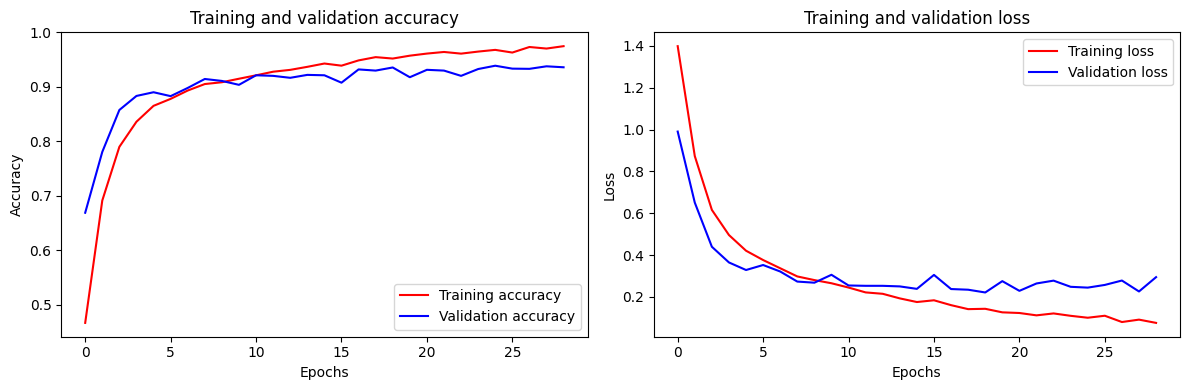

In [ ]:
plot_training_history(history)

### Evaluate the model performance

Run the model on the test set and check the model's performance:

In [ ]:
evaluate_model(model, test_mel_spec_ds)

Test accuracy:      92%
Test loss:          0.2530480921268463
Precision:,         0.9223639958907132
Recall:   ,         0.9215976331360947
F1-score:,          0.9212789274194777


## Confusion matrix

In [ ]:
y_pred = model.predict(test_mel_spec_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_mel_spec_ds.map(lambda s,lab: lab)), axis=0)
label_names_slice = ['ddyo', 'emabega', 'gaali', 'kkono', 'mumaaso', 'unknown', 'yimirira']

43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step


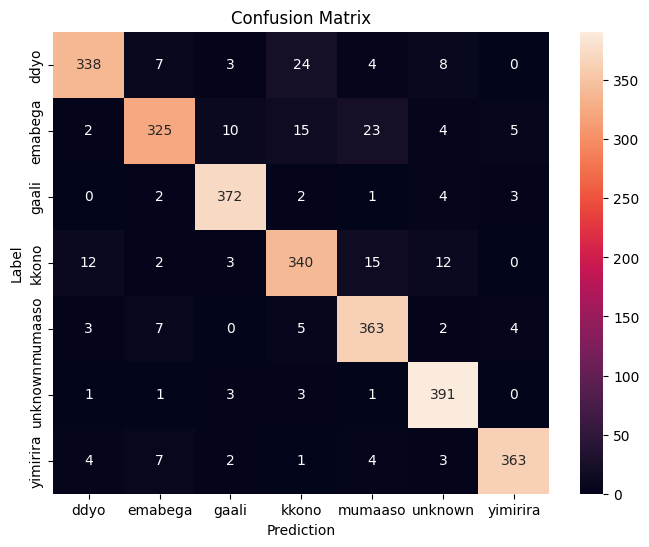

In [ ]:
plot_confusion_matrix(y_true, y_pred, label_names_slice)

## save the Keras model

In [ ]:
KERAS_MODEL_PATH = "model/spec_model_1.keras"

In [ ]:
model.save(KERAS_MODEL_PATH)

## Size of the keras model

In [ ]:
keras_model_size = get_and_convert_file_size(KERAS_MODEL_PATH, 'MB')

File size: 1.355 Megabytes
